In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('all/train.csv')
df_test = pd.read_csv('all/test.csv')

Here is the <a href='https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard'>kernel by Serigne</a> that explains well the procedure of imputing missing values for this dataset. I'm following the instructions from that kernel.  

The transformation of the DataFrame include the following steps:
- imputting missing values
- dropping several columns
- transforming several numerical values to categorial
- log-transform of the target variable and 'LotArea'

In [12]:
def FillWithNone(df,s_list):
    n = len(s_list)
    for i in range (n):
        df[s_list[i]].fillna('None',inplace=True)  

def FillWith0(df,s_list):
    n = len(s_list)
    for i in range (n):
        df[s_list[i]].fillna(0,inplace=True)  
        
def ToStrType(df,s_list):
    n = len(s_list)
    for i in range (n):
        df[s_list[i]] = df[s_list[i]].astype(str)  
        
def DropProblem(df,s_list):
    n = len(s_list)
    for i in range (n):
        df.drop([s_list[i]],axis=1,inplace=True)

# Transform DataFrame
# - imput missing values
# - drop several columns
# - log-transform the target variable
# - transform some numerical values to categorial
def TransformDataFrame(df):
    # this missing data is filled as described in the 
    # Serigne's kernel
    s_fill_None=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
                'GarageType','GarageFinish','GarageQual','GarageCond',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                'BsmtFinType2','MasVnrType','MSSubClass']
    s_fill_0=['GarageArea','GarageCars','BsmtFinSF1', 'BsmtFinSF2', 
              'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
              'MasVnrArea']
    s_to_str=['MSSubClass','OverallCond']
    FillWithNone(df,s_fill_None)
    FillWith0(df,s_fill_0)
    ToStrType(df,s_to_str)
    df['Functional'].fillna('Typ',inplace=True)
    df['Electrical'].fillna('SBrkr',inplace=True) # 1334
    df['Exterior1st'].fillna('VinylSd',inplace=True) # 515
    df['Exterior2nd'].fillna('VinylSd',inplace=True) # 504
    df['SaleType'].fillna('WD',inplace=True) # 1267
    df['MSZoning'].fillna('RL',inplace=True) # 1151
    df.drop(['Utilities'],axis=1,inplace=True)
    df['LotArea'] = df['LotArea'].apply(lambda x: np.log1p(x))
    df.drop(['GarageYrBlt'],axis=1,inplace=True) # highly correlated with YearBuilt
    df.drop(['LotFrontage'],axis=1,inplace=True) # too many values are missing
    df['KitchenQual'].fillna('miss',inplace=True) # no value significantly outnumbers others
    
    s_to_drop_problem=['MSSubClass','Condition2','HouseStyle','RoofMatl',
                      'Exterior1st','Exterior2nd','Heating','Electrical',
                      'KitchenQual','GarageQual','PoolQC','MiscFeature']
    DropProblem(df,s_to_drop_problem)
    
    # remove all categorial features
    strListObj = df.select_dtypes(include='object').columns.values
    print(strListObj)
    nObj=strListObj.size
    for i in range(nObj):
        if (strListObj[i]=='Neighborhood'): 
            print('I didn\'t touch Neighborhood')
            continue
        else: df.drop([strListObj[i]],axis=1,inplace=True)
    
# Transform DataFrame
TransformDataFrame(df)
TransformDataFrame(df_test)
df['SalePrice'] = df['SalePrice'].apply(lambda x: np.log1p(x))

print(df.shape)
print(df_test.shape)

['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'LotConfig'
 'LandSlope' 'Neighborhood' 'Condition1' 'BldgType' 'OverallCond'
 'RoofStyle' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual'
 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'HeatingQC'
 'CentralAir' 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish'
 'GarageCond' 'PavedDrive' 'Fence' 'SaleType' 'SaleCondition']
I didn't touch Neighborhood
['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'LotConfig'
 'LandSlope' 'Neighborhood' 'Condition1' 'BldgType' 'OverallCond'
 'RoofStyle' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual'
 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'HeatingQC'
 'CentralAir' 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish'
 'GarageCond' 'PavedDrive' 'Fence' 'SaleType' 'SaleCondition']
I didn't touch Neighborhood
(1460, 35)
(1459, 34)


In [14]:
df=pd.get_dummies(df)
df_test=pd.get_dummies(df_test)
print(df.shape)
print(df_test.shape)

(1460, 59)
(1459, 58)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

/sysroot/home/ekaterina/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/sysroot/home/ekaterina/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE test: 0.1607624694600041
RMSE train 0.12843992479628


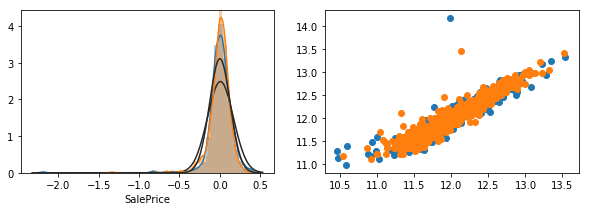

In [18]:
lm = LinearRegression()
X = df.drop(['SalePrice','Id'],axis=1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4, 
                                                    random_state=101)

lm.fit(X_train,y_train)

pred_test = lm.predict(X_test)
pred_train = lm.predict(X_train)

from scipy.stats import norm

def PlotComparison(y_test,y_train,pred_test,pred_train):
    fig, (ax1,ax2) = plt.subplots(figsize=(10,3),ncols=2)
    sns.distplot((y_test-pred_test),fit=norm,bins=50,ax=ax1)
    sns.distplot((y_train-pred_train),fit=norm,bins=50,ax=ax1)
    plt.scatter(y_test,pred_test)
    plt.scatter(y_train,pred_train)
    print('RMSE test:', np.sqrt(metrics.mean_squared_error(y_test, pred_test)))
    print('RMSE train', np.sqrt(metrics.mean_squared_error(y_train, pred_train)))
    
PlotComparison(y_test,y_train,pred_test,pred_train)

In [19]:
#Prepare submission

X_subm = df_test.drop('Id',axis=1)

pred_submit = np.expm1(lm.predict(X_subm))

file=open('submit078.csv','w')
file.write('Id,SalePrice\n')
for i in range(df_test.shape[0]):
    idTest=int(df_test.at[i,'Id'])
    
    price=pred_submit[i]
    
    file.write('{},{}\n'.format(idTest,price))
file.close()